## Imports

In [57]:
import os
import sys
import xgboost as xgb

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction import DictVectorizer

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.



### Dataset

In this homework, we will use the Students Performance in 2024 JAMB dataset from [Kaggle](https://www.kaggle.com/datasets/idowuadamo/students-performance-in-2024-jamb).

Here's a wget-able [link](https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv):

```bash
wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
```

The goal of this homework is to create a regression model for predicting the performance of students on a standardized test (column `'JAMB_Score'`).




In [3]:
!wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

--2024-10-29 23:03:34--  https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv [following]
--2024-10-29 23:03:35--  https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391501 (382K) [text/plain]
Saving to: ‘jamb_exam_results.csv’

jamb_exam_results.c 100%[===================>] 382,33K  2,24MB/s    in 0,2s    

2024-10-29 23:03:35 (2,24 MB/s) - ‘jamb_exam_result

In [1]:
!ls -lh

total 424K
-rw-rw-r-- 1 aztleclan aztleclan  29K oct 29 23:12 Homework.ipynb
-rw-rw-r-- 1 aztleclan aztleclan 4,1K oct 29 22:55 homework.md
-rw-rw-r-- 1 aztleclan aztleclan 383K oct 29 23:03 jamb_exam_results.csv


### Preparing the dataset 

First, let's make the names lowercase:

```python
df.columns = df.columns.str.lower().str.replace(' ', '_')
```

Preparation:

* Remove the `student_id` column.
* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [4]:
df = pd.read_csv('jamb_exam_results.csv')

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
df.head(5)

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [7]:
df = df.drop('student_id', axis=1)

In [8]:
df.head(5)

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,22,Female,Medium,Tertiary,1


In [15]:
df.columns

Index(['jamb_score', 'study_hours_per_week', 'attendance_rate',
       'teacher_quality', 'distance_to_school', 'school_type',
       'school_location', 'extra_tutorials', 'access_to_learning_materials',
       'parent_involvement', 'it_knowledge', 'age', 'gender',
       'socioeconomic_status', 'parent_education_level',
       'assignments_completed'],
      dtype='object')

In [9]:
seed=1

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

In [19]:
# Reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Y
y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

# Remove y
df_train = df_train.drop(columns=['jamb_score'])
df_val = df_val.drop(columns=['jamb_score'])
df_test = df_test.drop(columns=['jamb_score'])

In [20]:
print(f"df :{len(df)}, train :{len(df_train)} ({len(df_train)/len(df):.2f})%")
print(f"df :{len(df)}, val   :{len(df_val)} ({len(df_val)/len(df):.2f})%")
print(f"df :{len(df)}, test  :{len(df_test)} ({len(df_test)/len(df):.2f})%")

df :5000, train :3000 (0.60)%
df :5000, val   :1000 (0.20)%
df :5000, test  :1000 (0.20)%


In [21]:
# Aplicar DictVectorizer
vec = DictVectorizer(sparse=False)

# Convertir a diccionarios para DictVectorizer
X_train_dict = df_train.to_dict(orient='records')
X_val_dict = df_val.to_dict(orient='records')

X_train_encoded = vec.fit_transform(X_train_dict)
X_val_encoded = vec.transform(X_val_dict)

## Question 1

Let's train a decision tree regressor to predict the `jamb_score` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `study_hours_per_week`
* `attendance_rate`
* `teacher_quality`


In [25]:
dtr = DecisionTreeRegressor(max_depth=1)

In [26]:
dtr.fit(X_train_encoded, y_train)

DecisionTreeRegressor(max_depth=1)

In [35]:
feature_names = vec.get_feature_names_out()

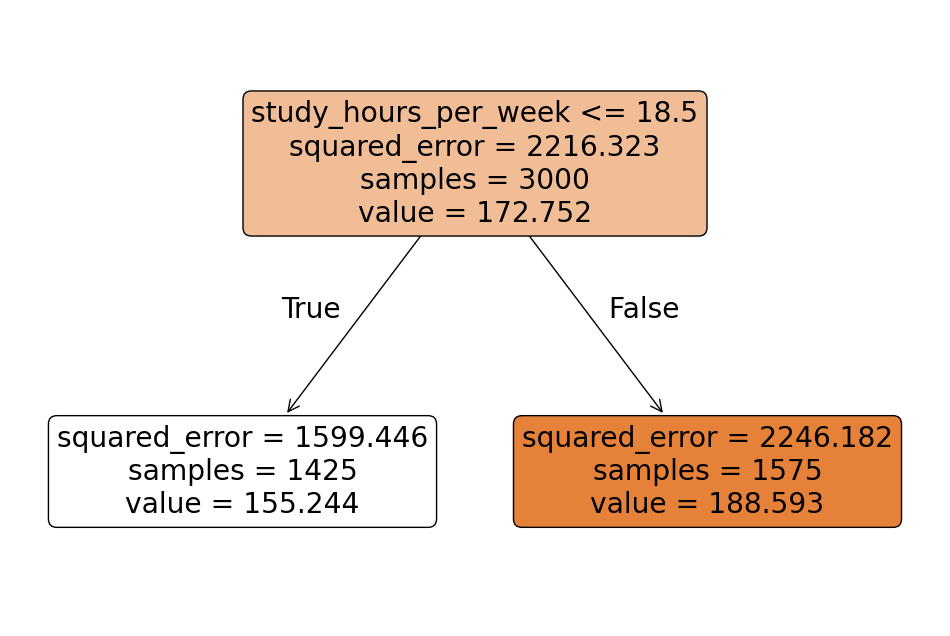

In [40]:
plt.figure(figsize=(12, 8))
plot_tree(dtr, filled=True, feature_names=feature_names.tolist(), rounded=True)
plt.show()

Which feature is used for splitting the data?

* **`study_hours_per_week`** <strong style="font-size: 24px;">&larr;</strong>
* `attendance_rate`
* `teacher_quality`

In [31]:
y_pred.shape

(3000,)

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)




What's the RMSE of this model on validation?

* 22.13
* 42.13
* 62.13
* 82.12


In [44]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [45]:
rf.fit(X_train_encoded, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [51]:
y_pred = rf.predict(X_val_encoded)

In [60]:
#mean_squared_error(y_val, y_pred, squared=False)
root_mean_squared_error(y_val, y_pred)

42.13724207871227

What's the RMSE of this model on validation?

* 22.13
* **42.13** <strong style="font-size: 24px;">&larr;</strong>
* 62.13
* 82.12


## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.




After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200

In [64]:
seed=1
results = {}
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=seed, n_jobs=-1)
    rf.fit(X_train_encoded, y_train)
    preds = rf.predict(X_val_encoded)
    #print("n_estimators=", n, "rmse=", round(mean_squared_error(y_val, preds, squared=False), 3))
    #print("n_estimators=", n, "rmse=", round(root_mean_squared_error(y_val, preds), 3))
    rmse = round(root_mean_squared_error(y_val, preds), 3)
    results[n] = rmse

In [70]:
# Convertir el mapa a un DataFrame de pandas
q3_results_df = pd.DataFrame(list(results.items()), columns=['Estimator', 'RMSE'])
#results_df

In [71]:
# Ordenar el DataFrame por RMSE de menor a mayor
q3_results_df = q3_results_df.sort_values(by='RMSE')

# Mostrar el DataFrame
print(q3_results_df)

    Estimator    RMSE
8          90  40.504
9         100  40.517
7          80  40.539
10        110  40.593
13        140  40.595
14        150  40.597
19        200  40.601
15        160  40.604
11        120  40.625
16        170  40.628
18        190  40.631
17        180  40.641
12        130  40.651
6          70  40.677
5          60  40.784
4          50  40.852
3          40  40.917
2          30  41.106
1          20  41.461
0          10  42.137


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10
- 25
- **80** <strong style="font-size: 24px;">&larr;</strong>
- 200

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`




What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [74]:
results = []
seed=1
for max_depth in [10, 15, 20, 25]:
    scores =  []
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(
            n_estimators=n, 
            max_depth=max_depth, 
            random_state=seed, 
            n_jobs=-1
        )
        rf.fit(X_train_encoded, y_train)
        preds = rf.predict(X_val_encoded)
        rmse = round(root_mean_squared_error(y_val, preds), 3)
        scores.append(rmse)
        #score.append(round(mean_squared_error(y_val, preds, squared=False), 3))
    #print("max_depth=", n, "rmse=", np.mean(score))
    results.append((max_depth, np.mean(scores)))

In [80]:
# Convertir el mapa a un DataFrame de pandas
results_df = pd.DataFrame(results, columns=['Max_depth', 'RMSE'])

In [81]:
# Ordenar el DataFrame por RMSE de menor a mayor
results_df = results_df.sort_values(by='RMSE')

# Mostrar el DataFrame
print(results_df)

   Max_depth      RMSE
0         10  40.39240
1         15  40.73535
2         20  40.73970
3         25  40.78785


What's the best `max_depth`, using the mean RMSE?

* **10** <strong style="font-size: 24px;">&larr;</strong>
* 15
* 20
* 25

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `study_hours_per_week`
* `attendance_rate`
* `distance_to_school`
* `teacher_quality`


In [84]:
q5_rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
q5_rf.fit(X_train_encoded, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [87]:
q5_rf.feature_importances_

array([0.0123254 , 0.01026189, 0.06931145, 0.03151679, 0.14972903,
       0.1364858 , 0.01345934, 0.00913136, 0.00928871, 0.01038263,
       0.01771934, 0.01240405, 0.00914148, 0.        , 0.01545036,
       0.01695692, 0.01448862, 0.02291885, 0.01335761, 0.01149201,
       0.00955909, 0.00923932, 0.0089532 , 0.00840598, 0.02571426,
       0.01070798, 0.01056268, 0.24835361, 0.08268222])

In [88]:
feature_names = vec.get_feature_names_out()

In [90]:
df_features = pd.DataFrame({
    'feature': feature_names,
    'value': q5_rf.feature_importances_
})

df_sorted = df_features.sort_values(by="value", ascending=False)
df_sorted

,feature,value
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311
3,assignments_completed,0.031517
24,socioeconomic_status=High,0.025714
17,parent_involvement=High,0.022919
10,it_knowledge=High,0.017719
15,parent_education_level=Secondary,0.016957


What's the most important feature (among these 4)? 

* **`study_hours_per_week`** <strong style="font-size: 24px;">&larr;</strong>
* `attendance_rate`
* `distance_to_school`
* `teacher_quality`


# Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.



Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [91]:
# Create DMatrix for train and validation
dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
dval = xgb.DMatrix(X_val_encoded, label=y_val)

In [92]:
# Create a watchlist
watchlist = [(dtrain, "train"), (dval, "dval")]

In [99]:
results_eta_0_3  = {}

In [101]:
# Train a model with these parameters for 100 rounds:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

#model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)
bst_eta_0_3 = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], 
                evals_result=results_eta_0_3)

[0]	eval-rmse:44.89114
[1]	eval-rmse:43.07010
[2]	eval-rmse:42.00332
[3]	eval-rmse:41.46452
[4]	eval-rmse:40.88896
[5]	eval-rmse:40.69096
[6]	eval-rmse:40.59315
[7]	eval-rmse:40.47993
[8]	eval-rmse:40.45326
[9]	eval-rmse:40.43929
[10]	eval-rmse:40.48319
[11]	eval-rmse:40.68201
[12]	eval-rmse:40.63522
[13]	eval-rmse:40.70983
[14]	eval-rmse:40.78133
[15]	eval-rmse:40.86107
[16]	eval-rmse:40.96580
[17]	eval-rmse:41.12190
[18]	eval-rmse:41.14360
[19]	eval-rmse:41.22835
[20]	eval-rmse:41.27921
[21]	eval-rmse:41.32427
[22]	eval-rmse:41.41887
[23]	eval-rmse:41.44451
[24]	eval-rmse:41.52684
[25]	eval-rmse:41.57975
[26]	eval-rmse:41.63976
[27]	eval-rmse:41.70697
[28]	eval-rmse:41.69887
[29]	eval-rmse:41.73703
[30]	eval-rmse:41.72928
[31]	eval-rmse:41.72136
[32]	eval-rmse:41.72436
[33]	eval-rmse:41.85049
[34]	eval-rmse:41.98504
[35]	eval-rmse:42.03417
[36]	eval-rmse:42.07600
[37]	eval-rmse:42.04571
[38]	eval-rmse:42.08106
[39]	eval-rmse:42.21377
[40]	eval-rmse:42.24363
[41]	eval-rmse:42.31689
[4

In [103]:
results_eta_0_1 = {}

In [104]:
# Now change eta from 0.3 to 0.1.
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

#model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)
bst_eta_0_1 = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], 
                evals_result=results_eta_0_1)

[0]	eval-rmse:47.00533
[1]	eval-rmse:45.92344
[2]	eval-rmse:44.98366
[3]	eval-rmse:44.25755
[4]	eval-rmse:43.57339
[5]	eval-rmse:43.11181
[6]	eval-rmse:42.61054
[7]	eval-rmse:42.18883
[8]	eval-rmse:41.86754
[9]	eval-rmse:41.64338
[10]	eval-rmse:41.39235
[11]	eval-rmse:41.14265
[12]	eval-rmse:40.95201
[13]	eval-rmse:40.81778
[14]	eval-rmse:40.75008
[15]	eval-rmse:40.61341
[16]	eval-rmse:40.51800
[17]	eval-rmse:40.41659
[18]	eval-rmse:40.33546
[19]	eval-rmse:40.25632
[20]	eval-rmse:40.25010
[21]	eval-rmse:40.19826
[22]	eval-rmse:40.21101
[23]	eval-rmse:40.14758
[24]	eval-rmse:40.15079
[25]	eval-rmse:40.12003
[26]	eval-rmse:40.08693
[27]	eval-rmse:40.08567
[28]	eval-rmse:40.07263
[29]	eval-rmse:40.14000
[30]	eval-rmse:40.13806
[31]	eval-rmse:40.11982
[32]	eval-rmse:40.13489
[33]	eval-rmse:40.16486
[34]	eval-rmse:40.17118
[35]	eval-rmse:40.16103
[36]	eval-rmse:40.19895
[37]	eval-rmse:40.19394
[38]	eval-rmse:40.20019
[39]	eval-rmse:40.18898
[40]	eval-rmse:40.17753
[41]	eval-rmse:40.19907
[4

In [105]:
# Después de entrenar el modelo con eta = 0.3
best_rmse_eta_0_3 = min(results_eta_0_3['eval']['rmse'])
print(f"Mejor RMSE con eta = 0.3: {best_rmse_eta_0_3}")

# Después de entrenar el modelo con eta = 0.1
best_rmse_eta_0_1 = min(results_eta_0_1['eval']['rmse'])
print(f"Mejor RMSE con eta = 0.1: {best_rmse_eta_0_1}")

Mejor RMSE con eta = 0.3: 40.43928983163436
Mejor RMSE con eta = 0.1: 40.07263360603788


Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* **0.1** <strong style="font-size: 24px;">&larr;</strong>
* Both give equal value

# Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2024/homework/hw06
* If your answer doesn't match options exactly, select the closest one